In [1]:

%pprint

Pretty printing has been turned OFF


In [8]:

import os
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%run ../load_magic/storage.py

s = Storage()
textures_dir = '../data/1.18.1_Default_Resource_Pack/assets/minecraft/textures/block'
if s.pickle_exists('AVERAGE_DICT') and s.pickle_exists('DOMINANT_DICT') and s.pickle_exists('WEIGHTED_AVERAGE_DICT'):
    AVERAGE_DICT = s.load_object('AVERAGE_DICT')
    DOMINANT_DICT = s.load_object('DOMINANT_DICT')
    WEIGHTED_AVERAGE_DICT = s.load_object('WEIGHTED_AVERAGE_DICT')
else:
    AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT = get_dictionaries(textures_dir, n_colors=5)
    s.store_objects(AVERAGE_DICT=AVERAGE_DICT, DOMINANT_DICT=DOMINANT_DICT, WEIGHTED_AVERAGE_DICT=WEIGHTED_AVERAGE_DICT)

In [9]:

def get_patches(textures_dir, file_name, average_dict, dominant_dict, weighted_dict, n_colors=5):

    # Read the image
    file_path = os.path.join(textures_dir, file_name)
    img_array = io.imread(file_path)[:, :, :3]

    # Calculate the mean of each chromatic channel
    average = average_dict[file_name]
    avg_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(average)

    # Create a palette with the most representative colors
    pixels = np.float32(img_array.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    # Get the palette color which occurs most frequently
    dominant = dominant_dict[file_name]
    dom_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(dominant)

    indices = np.argsort(counts)[::-1]
    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
    rows = np.int_(img_array.shape[0]*freqs)
    
    palette_patch = np.zeros(shape=img_array.shape, dtype=np.uint8)
    for i in range(len(rows) - 1):
        palette_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])

    # Calculate the mean of the palette patch
    weighted_average = weighted_dict[file_name]
    weighted_avg_patch = np.ones(shape=img_array.shape, dtype=np.uint8)*np.uint8(weighted_average)
    
    return img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch

In [71]:

def show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch):
    fig, (original_ax, average_ax, palette_ax, dominant_ax, weighted_avg_ax) = plt.subplots(1, 5, figsize=(12, 6))
    original_ax.imshow(img_array)
    original_ax.set_title('Original texture')
    original_ax.axis('off')
    average_ax.imshow(avg_patch)
    average_ax.set_title('Average color')
    average_ax.axis('off')
    palette_ax.imshow(palette_patch)
    palette_ax.set_title('Color palette')
    palette_ax.axis('off')
    dominant_ax.imshow(dom_patch)
    dominant_ax.set_title('Dominant color')
    dominant_ax.axis('off')
    weighted_avg_ax.imshow(weighted_avg_patch)
    weighted_avg_ax.set_title('Weighted average')
    weighted_avg_ax.axis('off')
    
    # Photometric/digital ITU BT.709 RGB -> Luma conversion formula
    red_value = int(dom_patch[0][0][0])
    green_value = int(dom_patch[0][0][1])
    blue_value = int(dom_patch[0][0][2])
    luminance = 0.2126*red_value + 0.7152*green_value + 0.0722*blue_value
    
    block_name = file_name.split('.')[0].replace('_', ' ').title()
    plt.suptitle(block_name + f' (Luminance: {luminance:.1f})', y=0.76)
#     fig.subplots_adjust(top=1.7)
#     fig.tight_layout(h_pad=30.0)
    plt.show(fig)
    
    return (luminance, file_name)

In [ ]:

blocks_list = ['black_concrete.png', 'blue_concrete.png', 'brown_concrete.png', 'cyan_concrete.png', 'gray_concrete.png', 'green_concrete.png',
               'light_blue_concrete.png', 'light_gray_concrete.png', 'lime_concrete.png', 'magenta_concrete.png', 'orange_concrete.png',
               'pink_concrete.png', 'purple_concrete.png', 'red_concrete.png', 'white_concrete.png', 'yellow_concrete.png', 'black_terracotta.png',
               'blue_terracotta.png', 'brown_terracotta.png', 'cyan_terracotta.png', 'gray_terracotta.png', 'green_terracotta.png',
               'light_blue_terracotta.png', 'light_gray_terracotta.png', 'lime_terracotta.png', 'magenta_terracotta.png', 'orange_terracotta.png',
               'pink_terracotta.png', 'purple_terracotta.png', 'red_terracotta.png', 'terracotta.png', 'white_terracotta.png', 'yellow_terracotta.png',
               'black_wool.png', 'blue_wool.png', 'brown_wool.png', 'cyan_wool.png', 'gray_wool.png', 'green_wool.png', 'light_blue_wool.png',
               'light_gray_wool.png', 'lime_wool.png', 'magenta_wool.png', 'orange_wool.png', 'pink_wool.png', 'purple_wool.png', 'red_wool.png',
               'white_wool.png', 'yellow_wool.png']
for file_name in sorted(blocks_list):
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT,
                                                                                     WEIGHTED_AVERAGE_DICT)
    show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)

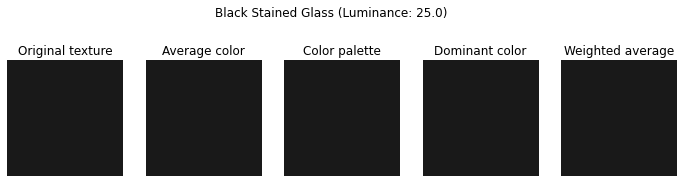

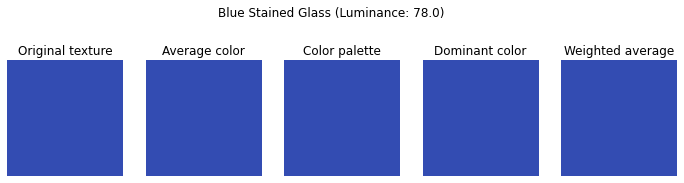

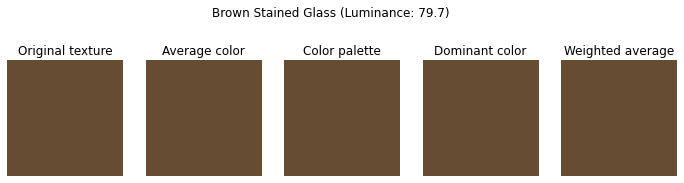

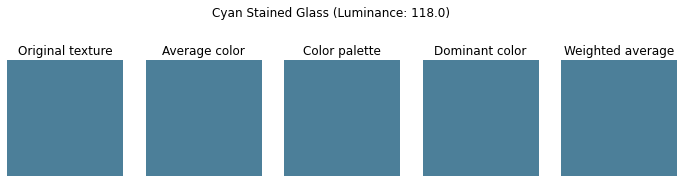

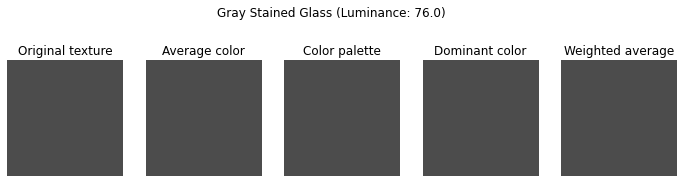

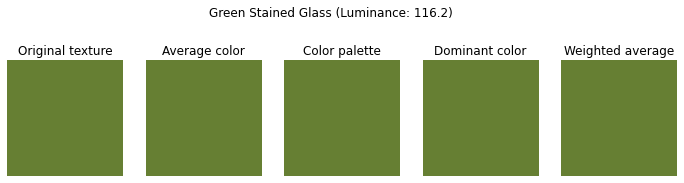

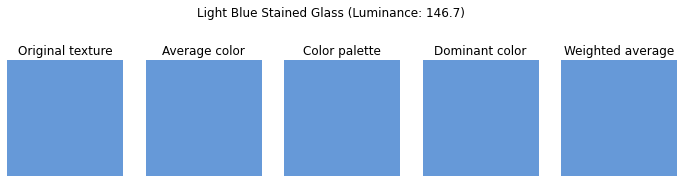

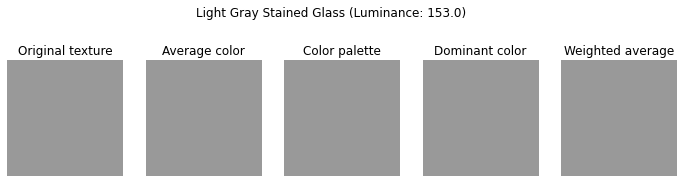

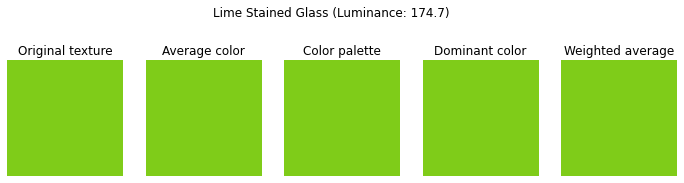

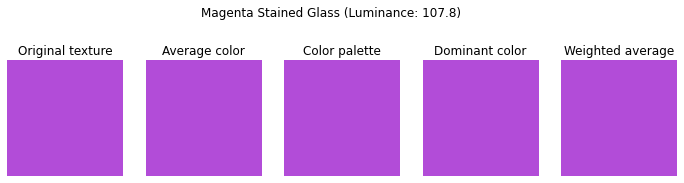

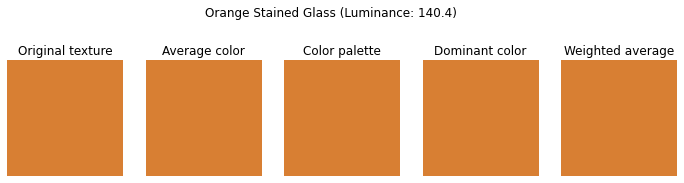

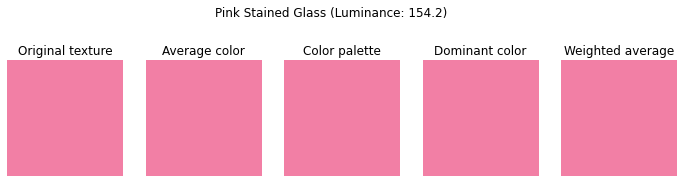

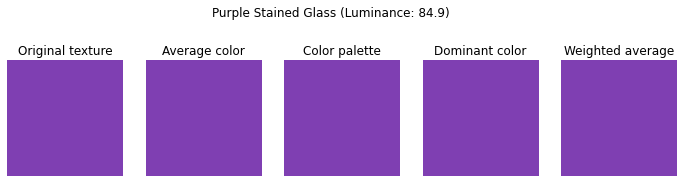

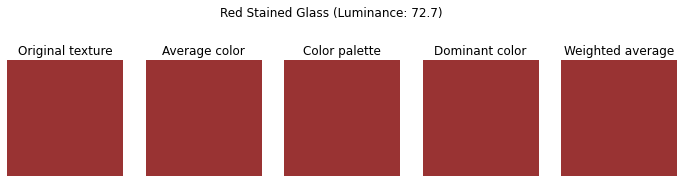

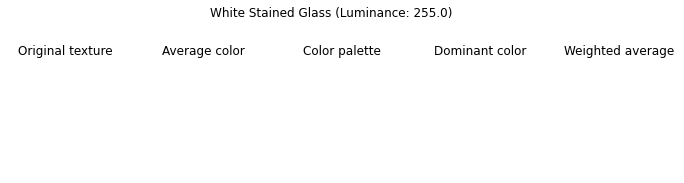

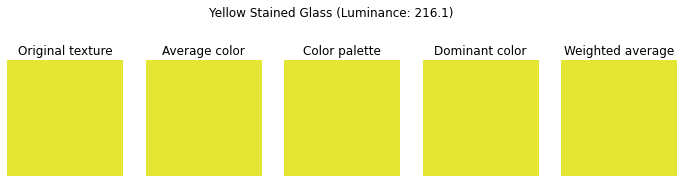

In [76]:

blocks_list = [key for key in WEIGHTED_AVERAGE_DICT.keys() if key.endswith('_stained_glass.png')]
for file_name in sorted(blocks_list):
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT,
                                                                                     WEIGHTED_AVERAGE_DICT)
    show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)


----

In [3]:

def get_dictionaries(textures_dir, n_colors=5):
    average_dict = {}
    dominant_dict = {}
    weighted_dict = {}
    for file_name in os.listdir(textures_dir):
        if file_name.endswith('.png'):

            # Read the image
            file_path = os.path.join(textures_dir, file_name)
            try:
                img_array = io.imread(file_path)[:, :, :3]
                if img_array.shape == (16, 16, 3):
                    
                    # Calculate the mean of each chromatic channel
                    average = img_array.mean(axis=0).mean(axis=0)
                    average_dict[file_name] = tuple(average)
                    
                    # Get the palette color which occurs most frequently
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
                    flags = cv2.KMEANS_RANDOM_CENTERS
                    pixels = np.float32(img_array.reshape(-1, 3))
                    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
                    _, counts = np.unique(labels, return_counts=True)
                    dominant = palette[np.argmax(counts)]
                    dominant_dict[file_name] = tuple(dominant)
                    
                    # Calculate the mean of the palette patch
                    indices = np.argsort(counts)[::-1]   
                    freqs = np.cumsum(np.hstack([[0], counts[indices]/float(counts.sum())]))
                    rows = np.int_(img_array.shape[0]*freqs)
                    palette_patch = np.zeros(shape=img_array.shape, dtype=np.uint8)
                    for i in range(len(rows) - 1):
                        palette_patch[rows[i]:rows[i + 1], :, :] += np.uint8(palette[indices[i]])
                    weighted_average = palette_patch.mean(axis=0).mean(axis=0)
                    weighted_dict[file_name] = tuple(weighted_average)
            except IndexError as e:
                print(f'{file_name}: {str(e).strip()}')
    
    return average_dict, dominant_dict, weighted_dict

In [13]:

# textures_dir = '../data/1.15_Default_Resource_Pack/assets/minecraft/textures/block'
if s.pickle_exists('minecraft_blocks_list'):
    blocks_list = s.load_object('minecraft_blocks_list')
else:
    blocks_list = ['acacia_log.png', 'acacia_log_top.png', 'acacia_planks.png', 'andesite.png', 'birch_log.png',
                   'birch_log_top.png', 'birch_planks.png', 'black_concrete.png', 'black_concrete_powder.png', 'black_glazed_terracotta.png',
                   'black_terracotta.png', 'black_wool.png', 'blue_concrete.png', 'blue_concrete_powder.png', 'blue_glazed_terracotta.png',
                   'blue_terracotta.png', 'blue_wool.png', 'bone_block_side.png', 'bone_block_top.png',
                   'bookshelf.png', 'bricks.png', 'brown_concrete.png', 'brown_concrete_powder.png', 'brown_glazed_terracotta.png',
                   'brown_terracotta.png', 'brown_wool.png', 'chiseled_nether_bricks.png', 'chiseled_quartz_block.png',
                   'chiseled_quartz_block_top.png', 'chiseled_red_sandstone.png', 'chiseled_sandstone.png', 'chiseled_stone_bricks.png', 'coal_block.png',
                   'coal_ore.png', 'cobblestone.png', 'cracked_nether_bricks.png', 'cracked_stone_bricks.png',
                   'cyan_concrete.png', 'cyan_concrete_powder.png', 'cyan_glazed_terracotta.png',
                   'cyan_terracotta.png', 'cyan_wool.png', 'dark_oak_log.png', 'dark_oak_log_top.png', 'dark_oak_planks.png',
                   'dark_prismarine.png', 'diamond_block.png', 'diorite.png', 'dirt.png',
                   'emerald_block.png', 'end_stone.png', 'end_stone_bricks.png', 'furnace_front.png',
                   'furnace_side.png', 'furnace_top.png',
                   'granite.png', 'grass_block_side.png', 'gravel.png',
                   'gray_concrete.png', 'gray_concrete_powder.png', 'gray_glazed_terracotta.png', 'gray_terracotta.png', 'gray_wool.png',
                   'green_concrete.png', 'green_concrete_powder.png', 'green_glazed_terracotta.png', 'green_terracotta.png', 'green_wool.png',
                   'hay_block_side.png', 'hay_block_top.png', 'iron_block.png', 'iron_ore.png',
                   'jack_o_lantern.png', 'jungle_log.png', 'jungle_log_top.png',
                   'jungle_planks.png', 'lapis_block.png', 'light_blue_concrete.png', 'light_blue_concrete_powder.png',
                   'light_blue_glazed_terracotta.png', 'light_blue_terracotta.png', 'light_blue_wool.png', 'light_gray_concrete.png', 'light_gray_concrete_powder.png',
                   'light_gray_glazed_terracotta.png', 'light_gray_terracotta.png', 'light_gray_wool.png', 'lime_concrete.png', 'lime_concrete_powder.png',
                   'lime_glazed_terracotta.png', 'lime_terracotta.png', 'lime_wool.png', 'magenta_concrete.png', 'magenta_concrete_powder.png',
                   'magenta_glazed_terracotta.png', 'magenta_terracotta.png', 'magenta_wool.png', 'melon_side.png', 'melon_top.png',
                   'mossy_cobblestone.png', 'mossy_stone_bricks.png',
                   'netherite_block.png', 'netherrack.png', 'nether_bricks.png', 'nether_quartz_ore.png', 'nether_wart_block.png',
                   'note_block.png', 'oak_log.png', 'oak_log_top.png', 'oak_planks.png', 'orange_concrete.png',
                   'orange_concrete_powder.png', 'orange_glazed_terracotta.png', 'orange_terracotta.png', 'orange_wool.png', 'packed_ice.png',
                   'pink_concrete.png', 'pink_concrete_powder.png', 'pink_glazed_terracotta.png', 'pink_terracotta.png', 'pink_wool.png',
                   'piston_side.png', 'piston_top.png', 'piston_top_sticky.png', 'podzol_side.png',
                   'polished_andesite.png', 'polished_diorite.png', 'polished_granite.png', 'prismarine_bricks.png', 'pumpkin_side.png',
                   'pumpkin_top.png', 'purple_concrete.png', 'purple_concrete_powder.png', 'purple_glazed_terracotta.png', 'purple_terracotta.png',
                   'purple_wool.png', 'purpur_block.png', 'purpur_pillar.png', 'purpur_pillar_top.png', 'quartz_block_side.png',
                   'quartz_block_top.png', 'quartz_bricks.png', 'quartz_pillar.png', 'quartz_pillar_top.png', 'redstone_block.png',
                   'redstone_lamp.png', 'redstone_ore.png', 'red_concrete.png', 'red_concrete_powder.png', 'red_glazed_terracotta.png',
                   'red_nether_bricks.png', 'red_sand.png', 'red_sandstone.png', 'red_sandstone_top.png', 'red_terracotta.png',
                   'red_wool.png', 'sand.png', 'sandstone.png', 'sandstone_top.png', 'slime_block.png',
                   'smooth_stone.png', 'smooth_stone_slab_side.png', 'soul_sand.png', 'sponge.png',
                   'spruce_log.png', 'spruce_log_top.png', 'spruce_planks.png', 'stone.png', 'stone_bricks.png',
                   'terracotta.png', 'wet_sponge.png', 'white_concrete.png', 'white_concrete_powder.png',
                   'white_glazed_terracotta.png', 'white_terracotta.png', 'white_wool.png', 'yellow_concrete.png', 'yellow_concrete_powder.png',
                   'yellow_glazed_terracotta.png', 'yellow_terracotta.png', 'yellow_wool.png']
    s.store_objects(minecraft_blocks_list=blocks_list)

In [7]:

if s.pickle_exists('minecraft_glass_and_concrete_list') and s.pickle_exists('minecraft_concrete_list') and s.pickle_exists('minecraft_glass_list'):
    minecraft_glass_and_concrete_list = s.load_object('minecraft_glass_and_concrete_list')
    minecraft_concrete_list = s.load_object('minecraft_concrete_list')
    minecraft_glass_list = s.load_object('minecraft_glass_list')
else:
    glass_and_concrete_list = []
    concrete_list = []
    for file_name in AVERAGE_DICT.keys():
        if ('concrete' in file_name):
            img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
            show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)
            glass_and_concrete_list.append(file_name)
            concrete_list.append(file_name)
    glass_list = []
    for file_name in AVERAGE_DICT.keys():
        if ('glass' in file_name) and ('pane' not in file_name):
            img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
            show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)
            glass_and_concrete_list.append(file_name)
            glass_list.append(file_name)
    s.store_objects(minecraft_glass_and_concrete_list=glass_and_concrete_list, minecraft_concrete_list=concrete_list, minecraft_glass_list=glass_list)

In [8]:

if s.pickle_exists('minecraft_glass_and_concrete_and_terracotta_list'):
    glass_and_concrete_and_terracotta_list = s.load_object('minecraft_glass_and_concrete_and_terracotta_list')
else:
    glass_and_concrete_and_terracotta_list = glass_list + concrete_list + [key for key in DOMINANT_DICT.keys() if 'terracotta' in key.lower()]
    s.store_objects(minecraft_glass_and_concrete_and_terracotta_list=glass_and_concrete_and_terracotta_list)
if s.pickle_exists('minecraft_glass_and_terracotta_list'):
    glass_and_terracotta_list = s.load_object('minecraft_glass_and_terracotta_list')
else:
    glass_and_terracotta_list = glass_list + [key for key in DOMINANT_DICT.keys() if 'terracotta' in key.lower()]
    s.store_objects(minecraft_glass_and_terracotta_list=glass_and_terracotta_list)
if s.pickle_exists('minecraft_terracotta_list'):
    terracotta_list = s.load_object('minecraft_terracotta_list')
else:
    terracotta_list = [key for key in DOMINANT_DICT.keys() if 'terracotta' in key.lower()]
    s.store_objects(minecraft_terracotta_list=terracotta_list)

In [9]:

if s.pickle_exists('minecraft_glass_and_concrete_and_unglazed_terracotta_list'):
    glass_and_concrete_and_unglazed_terracotta_list = s.load_object('minecraft_glass_and_concrete_and_unglazed_terracotta_list')
else:
    glass_and_concrete_and_unglazed_terracotta_list = [fn for fn in glass_and_concrete_and_terracotta_list if 'glazed' not in fn]
    s.store_objects(minecraft_glass_and_concrete_and_unglazed_terracotta_list=glass_and_concrete_and_unglazed_terracotta_list)

In [10]:

if s.pickle_exists('minecraft_concrete_and_unglazed_terracotta_list'):
    concrete_and_unglazed_terracotta_list = s.load_object('minecraft_concrete_and_unglazed_terracotta_list')
else:
    concrete_and_unglazed_terracotta_list = [fn for fn in concrete_list + terracotta_list if 'glazed' not in fn]
    s.store_objects(minecraft_concrete_and_unglazed_terracotta_list=concrete_and_unglazed_terracotta_list)

In [11]:

if s.pickle_exists('minecraft_wool_list'):
    wool_list = s.load_object('minecraft_wool_list')
else:
    wool_list = [fn for fn in blocks_list if 'wool' in fn]
    s.store_objects(minecraft_wool_list=wool_list)

In [14]:

import pandas as pd
from PIL import Image
from IPython.display import HTML
from pathlib import Path
import webbrowser
import traceback

def show_art_recipe(file_path, rgb_dict=WEIGHTED_AVERAGE_DICT, blocks_list=None):
    if blocks_list is not None:
        rgb_dict = {k: v for k, v in rgb_dict.items() if k in blocks_list}
    file_prefix = file_path.split('/')[-1].split('.')[0]
    rows_list = []
    minecraft_pixel_art_img = Image.open(file_path)
    img_array = np.array(minecraft_pixel_art_img)
    row_count = img_array.shape[0]
    col_count = img_array.shape[1]
    text_html_str = image_html_str = '<table style="border-collapse:collapse;">'
    img_style = 'display:block;margin:0!important;padding:0!important;border:0!important;'
    td_style = 'padding:0;margin:0;'
    for row in range(row_count):
        text_html_str += '<tr>'
        for col in range(col_count):
            file_name = sorted(rgb_dict.items(),
                                key=lambda item: np.linalg.norm(np.array(item[1])-img_array[row][col]))[0][0]
            img_path = os.path.abspath(f'{textures_dir}/{file_name}')
            block_name = file_name.split('.')[0].replace('_', ' ').title()
            text_html_str += f'''<td style="background-image:url('file:///{img_path}');background-size:100% 100%;background-repeat:no-repeat;">{block_name}</td>'''
            image_html_str += f'<td title="{block_name}" style="{td_style}"><img src="file:///{img_path}" style="{img_style}" /></td>'
            row_dict = {}
            row_dict['row_number'] = row
            row_dict['column_number'] = col
            row_dict['block_name'] = block_name
            rows_list.append(row_dict)
        text_html_str += '</tr>'
        if row==0:
            title = file_prefix.replace('_', ' ').title()
            src_url = 'file:///' + os.path.abspath(file_path).replace(os.sep, '/')
            image_str = f'<img src="{src_url}" style="display:block;" width="100%" height="100%" />'
            image_td_style = f"{td_style}background-image:url('{src_url}');background-size:cover;background-position:center;"
            image_html_str += f'<td title="{title}" style="{image_td_style}" rowspan={row_count} width="{col_count*16}px"></td>'
        image_html_str += '</tr>'
    block_names_df = pd.DataFrame(rows_list)
    text_html_str += '</table><hr />'
    image_html_str += '</table>'
    display(HTML(text_html_str))
    html_path = os.path.abspath(f'../saves/html/{file_prefix}.html')
    os.makedirs(name=os.path.dirname(html_path), exist_ok=True)
    Path(html_path).touch()
    _, _, _, code = traceback.extract_stack()[-2]
    with open(html_path, 'w') as f:
        f.write(f'<html><head><title>{code}</title></head><body>')
        f.write(image_html_str)
        f.write('</body></html>')
    block_names_series = block_names_df.block_name.value_counts()
    for column_name, column_value in block_names_series.iteritems():
        stack_count = (column_value // 64) + 1
        stack_str = 's' if stack_count > 1 else ''
        line_count = (column_value // (64*9)) + 1
        line_str = 's' if line_count > 1 else ''
        chest_count = (column_value // (64*9*3)) + 1
        chest_str = 's' if chest_count > 1 else ''
        it_str = 'them' if chest_count > 1 else 'it'
        print(f'{column_name}: {column_value:,} ({chest_count} chest{chest_str} with {line_count} line{line_str}/{stack_count} stack{stack_str} in {it_str}, total)')
    webbrowser.open(html_path, new=2)


----

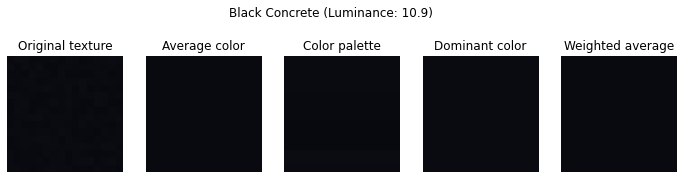

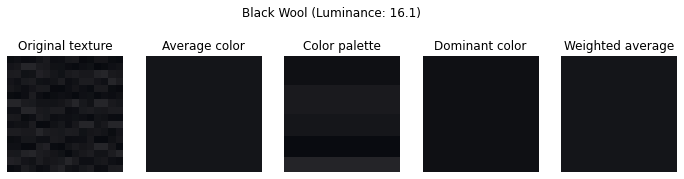

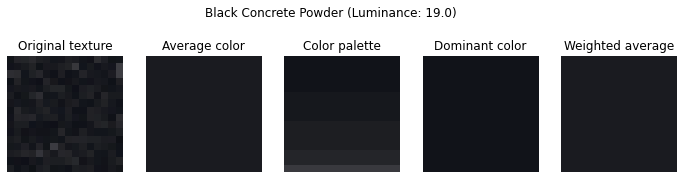

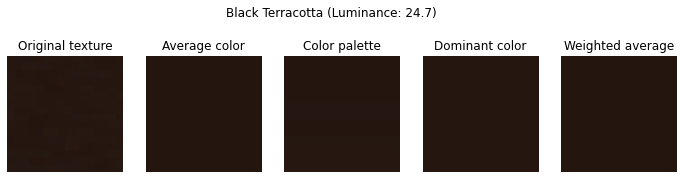

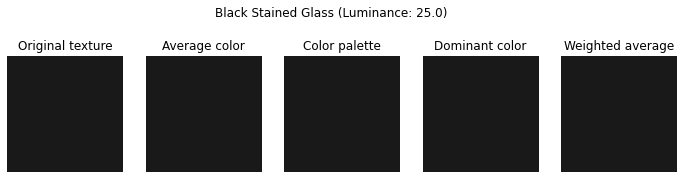

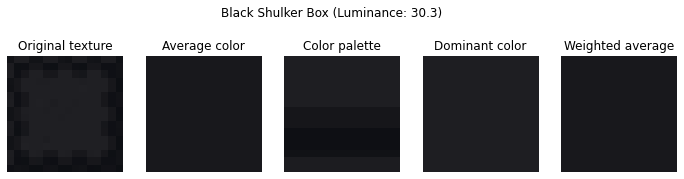

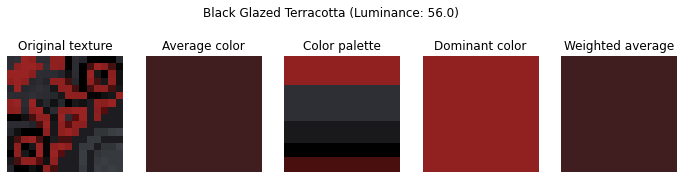

In [83]:

black_blocks_list = ['black_concrete.png', 'black_wool.png', 'black_concrete_powder.png', 'black_terracotta.png', 'black_stained_glass.png',
                     'black_shulker_box.png', 'black_glazed_terracotta.png']
for file_name in black_blocks_list:
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
    block_tuple = show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)

In [ ]:

block_tuples_list = []
for file_name in [key for key in WEIGHTED_AVERAGE_DICT.keys() if 'wool' in key.lower()]:
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
    block_tuple = show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)
    block_tuples_list.append(block_tuple)
wool_blocks_list = [tuple[1] for tuple in sorted(block_tuples_list)]

In [30]:

[key for key in WEIGHTED_AVERAGE_DICT.keys() if 'iron' in key.lower()]

['deepslate_iron_ore.png', 'iron_bars.png', 'iron_block.png', 'iron_door_bottom.png', 'iron_door_top.png', 'iron_ore.png', 'iron_trapdoor.png', 'raw_iron_block.png']

['black_wool.png', 'blue_wool.png', 'brown_wool.png', 'cyan_wool.png', 'gray_wool.png', 'green_wool.png', 'light_blue_wool.png', 'light_gray_wool.png', 'lime_wool.png', 'magenta_wool.png', 'orange_wool.png', 'pink_wool.png', 'purple_wool.png', 'red_wool.png', 'white_wool.png', 'yellow_wool.png']


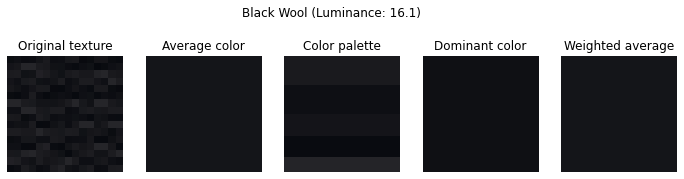

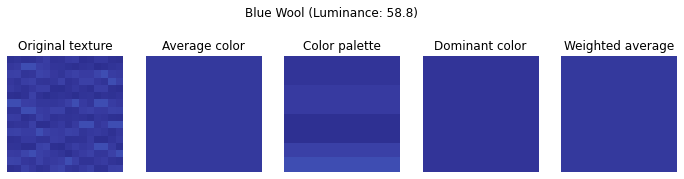

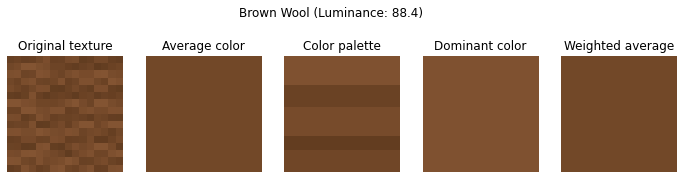

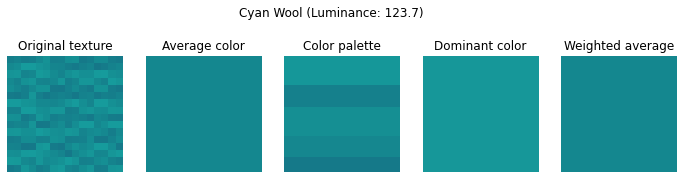

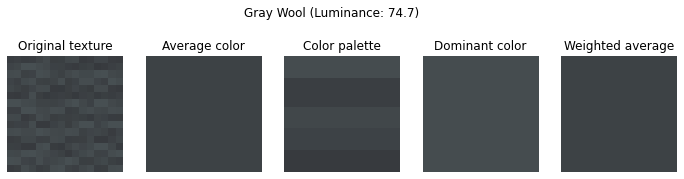

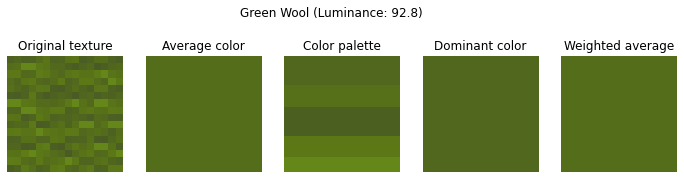

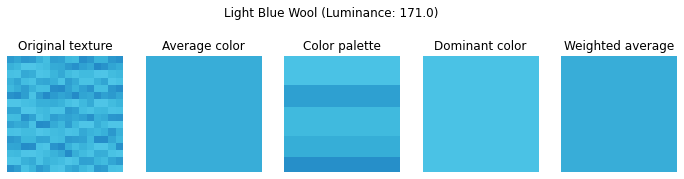

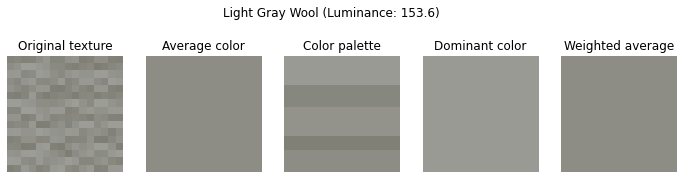

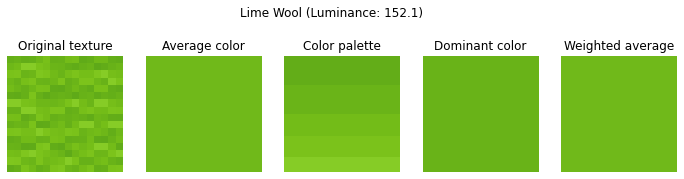

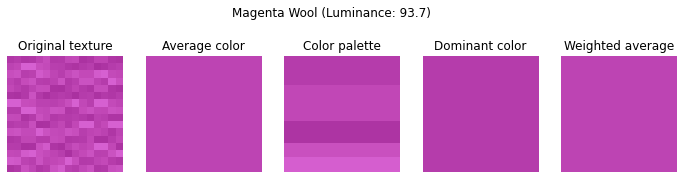

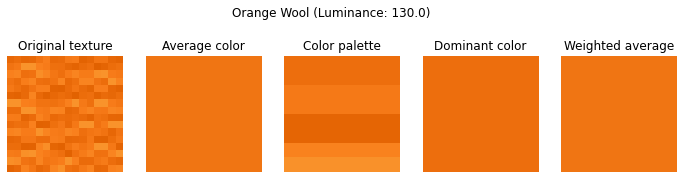

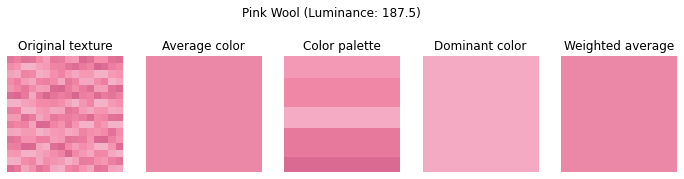

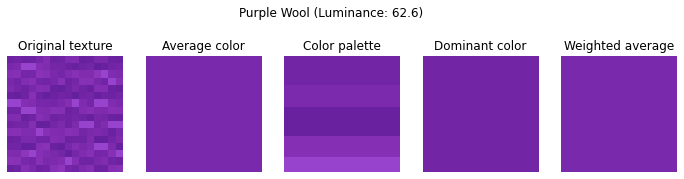

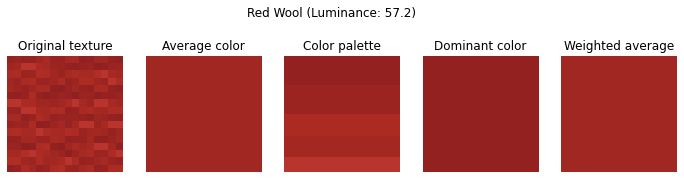

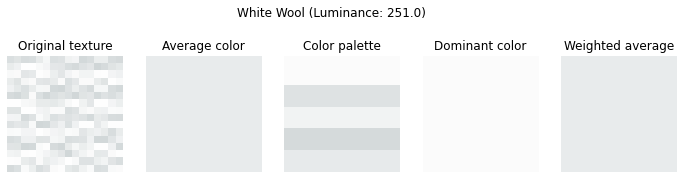

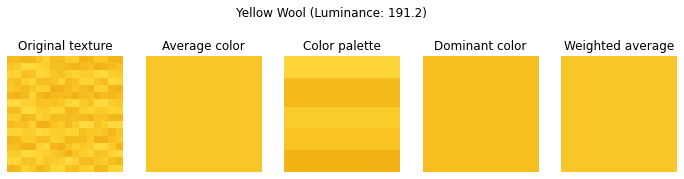

In [87]:

wool_blocks_list = sorted(wool_blocks_list)
print(wool_blocks_list)
for file_name in wool_blocks_list:
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
    block_tuple = show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)

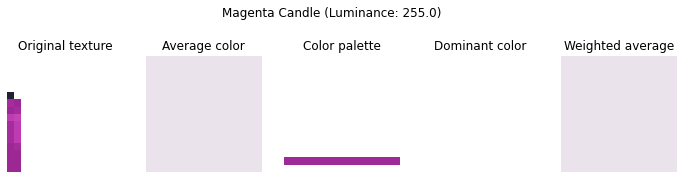

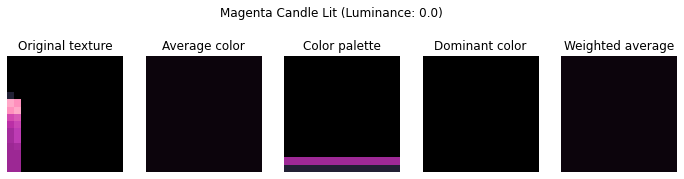

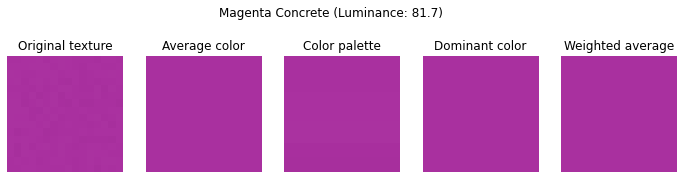

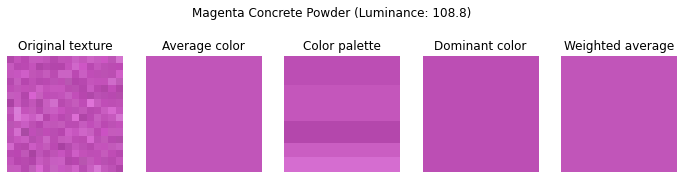

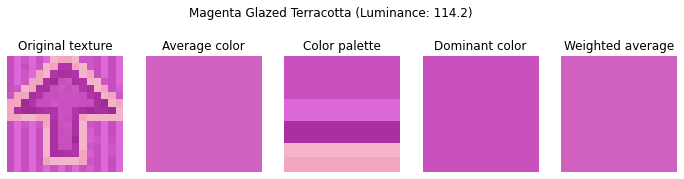

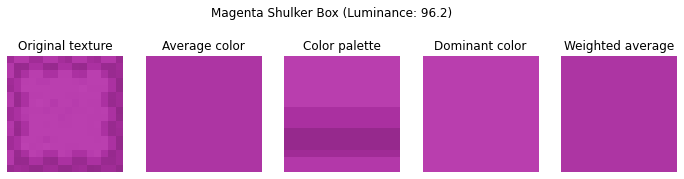

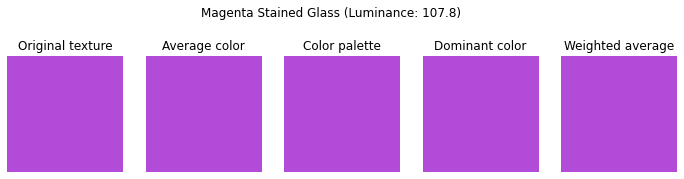

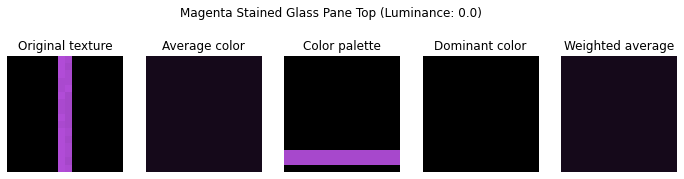

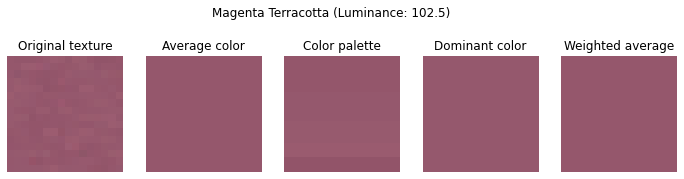

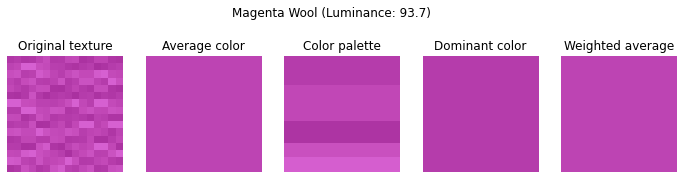

In [88]:

for file_name in [key for key in WEIGHTED_AVERAGE_DICT.keys() if 'magenta' in key.lower()]:
    img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(textures_dir, file_name, AVERAGE_DICT, DOMINANT_DICT, WEIGHTED_AVERAGE_DICT)
    block_tuple = show_images(file_name, img_array, avg_patch, dom_patch, palette_patch, weighted_avg_patch)


----

In [ ]:

file_path = '../saves/png/minecraft_pixel_art.png'
show_art_recipe(file_path, rgb_dict=WEIGHTED_AVERAGE_DICT, blocks_list=[key for key in WEIGHTED_AVERAGE_DICT.keys() if 'black' in key.lower()])

In [ ]:

file_path = '../saves/png/fusion_logo59x59.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=terracotta_list)

In [ ]:

file_path = '../saves/png/fusion_logo143x143.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=terracotta_list)

In [ ]:

file_path = '../saves/png/fusion_logo143x143.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_list)

In [ ]:

file_path = '../saves/png/fusion_logo143x143.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=glass_and_concrete_and_unglazed_terracotta_list)

In [ ]:

file_path = '../saves/png/red_shuriken150x135.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_and_unglazed_terracotta_list+wool_list)

In [ ]:

file_path = '../saves/png/jayz_vape70x180.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=glass_and_concrete_and_unglazed_terracotta_list)

In [ ]:

file_path = '../saves/png/fusion_logo143x143.png'
show_art_recipe(file_path, rgb_dict=WEIGHTED_AVERAGE_DICT, blocks_list=blocks_list)

In [ ]:

file_path = '../saves/png/dbabbitt46x46.png'
show_art_recipe(file_path, rgb_dict=WEIGHTED_AVERAGE_DICT, blocks_list=blocks_list)

In [ ]:

file_path = '../saves/png/jayz_vape70x180.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_and_unglazed_terracotta_list)

In [ ]:

file_path = '../saves/png/jayz_vape70x180.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_list+terracotta_list)

In [ ]:

file_path = '../saves/png/jayz_vape70x180.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_list)

In [ ]:

file_path = '../saves/png/jayz_vape70x180.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_and_unglazed_terracotta_list+wool_list)

In [ ]:

file_path = '../saves/png/navajo_basket90x90.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_and_unglazed_terracotta_list+wool_list)

In [ ]:

file_path = '../saves/png/red_shuriken41x41.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT, blocks_list=concrete_and_unglazed_terracotta_list+wool_list)

In [40]:

file_path = '../saves/png/melee_design.png'
show_art_recipe(file_path, rgb_dict=DOMINANT_DICT,
                blocks_list=concrete_and_unglazed_terracotta_list+wool_list)

White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Light Gray Concrete Powder,Light Gray Concrete,Cyan Terracotta,Gray Concrete,Gray Terracotta,Gray Concrete,Cyan Terracotta,Light Gray Concrete,Light Gray Concrete Powder,White Concrete,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Light Gray Concrete,Gray Terracotta,Black Terracotta,Gray Terracotta,Gray Terracotta,Gray Concrete,Gray Concrete,Gray Wool,Gray Concrete,Gray Wool,Gray Concrete,Gray Concrete,Gray Terracotta,Black Terracotta,Light Gray Concrete,White Concrete,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Cyan Terracotta,Gray Terracotta,Gray Terracotta,Gray Terracotta,Gray Concrete,Gray Concrete Powder,Cyan Terracotta,Light Gray Concrete,Light Gray Wool,Light Gray Wool,Cyan Terracotta,Cyan Terracotta,Cyan Terracotta,Gray Concrete Powder,Cyan Terracotta,Cyan Terracotta,Gray Wool,Gray Terracotta,Cyan Terracotta,White Concrete,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete Powder,Light Gray Concrete,Gray Terracotta,Gray Terracotta,Gray Concrete,Gray Concrete,Gray Concrete Powder,Light Gray Terracotta,Light Gray Concrete Powder,Light Gray Wool,Cyan Terracotta,Gray Concrete,Gray Concrete Powder,Light Gray Concrete,Light Gray Concrete,Light Gray Concrete,Light Gray Concrete,Light Gray Concrete,Cyan Terracotta,Gray Concrete Powder,Gray Concrete Powder,Cyan Terracotta,Gray Terracotta,Light Gray Concrete,White Concrete Powder,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Gray Wool,Gray Terracotta,Gray Terracotta,Gray Concrete,Cyan Terracotta,Light Gray Concrete,Light Gray Concrete Powder,White Terracotta,Cyan Terracotta,Green Terracotta,Light Gray Concrete,Light Gray Concrete Powder,White Terracotta,White Concrete,White Concrete,White Concrete Powder,White Terracotta,White Terracotta,White Terracotta,Light Gray Wool,Light Gray Concrete,Cyan Terracotta,Cyan Terracotta,Gray Concrete,Gray Concrete,White Concrete,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Gray Terracotta,Gray Terracotta,Gray Concrete,Cyan Terracotta,Light Gray Terracotta,Light Gray Wool,White Concrete Powder,White Terracotta,Gray Concrete Powder,Light Gray Concrete,White Terracotta,White Concrete Powder,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete Powder,White Concrete,Light Gray Concrete Powder,Light Gray Wool,Light Gray Concrete,Gray Concrete Powder,Gray Concrete,Black Terracotta,White Concrete,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool
White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete,Gray Terracotta,Gray Concrete,Gray Concrete Powder,Cyan Terracotta,White Terracotta,Gray Concrete Powder,Light Gray Wool,Light Gray Concrete,Light Gray Terracotta,White Terracotta,White Concrete Powder,White Wool,White Wool,White Wool,White Wool,White Wool,White Wool,White Concrete Powder,White Concrete Powder,White Concrete Powder,White Concrete Powder,White Concrete Powder,White Concrete Powder,White Concrete Powder,Light Gray Concrete Pow

White Wool: 417 (1 chest with 1 line/7 stacks in it, total)
Light Gray Concrete: 177 (1 chest with 1 line/3 stacks in it, total)
Cyan Terracotta: 163 (1 chest with 1 line/3 stacks in it, total)
Gray Concrete: 146 (1 chest with 1 line/3 stacks in it, total)
Gray Terracotta: 135 (1 chest with 1 line/3 stacks in it, total)
White Concrete: 117 (1 chest with 1 line/2 stacks in it, total)
White Concrete Powder: 85 (1 chest with 1 line/2 stacks in it, total)
Gray Concrete Powder: 81 (1 chest with 1 line/2 stacks in it, total)
Light Gray Concrete Powder: 68 (1 chest with 1 line/2 stacks in it, total)
White Terracotta: 66 (1 chest with 1 line/2 stacks in it, total)
Black Terracotta: 56 (1 chest with 1 line/1 stack in it, total)
Gray Wool: 56 (1 chest with 1 line/1 stack in it, total)
Light Gray Wool: 41 (1 chest with 1 line/1 stack in it, total)
Light Gray Terracotta: 24 (1 chest with 1 line/1 stack in it, total)
Black Concrete Powder: 23 (1 chest with 1 line/1 stack in it, total)
Black Wool: 1


----

In [88]:

WEIGHTED_AVERAGE_DICT['black_concrete.png'], WEIGHTED_AVERAGE_DICT['lapis_block.png']

((8.375, 10.375, 15.375), (30.0, 66.375, 138.9375))

In [ ]:

textures_dir = '../data/1.15_Default_Resource_Pack/assets/minecraft/textures/block'
blocks_list = []
for file_name in os.listdir(textures_dir):
    if file_name.endswith('.png') and ('terracotta' in file_name):
        
        # Read the image
        file_path = os.path.join(textures_dir, file_name)
        img_array = io.imread(file_path)[:, :, :-1]
        if img_array.shape == (16, 16, 3):
            avg_patch, dom_patch, palette_patch, weighted_avg_patch = get_patches(img_array)
            show_images(file_name, avg_patch, dom_patch, palette_patch, weighted_avg_patch)
            blocks_list.append(file_name)

In [86]:

def quantizetopalette(silf, palette, dither=False):
    '''Convert an RGB or L mode image to use a given P image's palette.'''

    silf.load()

    # Use palette from reference image
    palette.load()
    if palette.mode != 'P':
        raise ValueError('bad mode for palette image')
    if silf.mode != 'RGB' and silf.mode != 'L':
        raise ValueError(
            'only RGB or L mode images can be quantized to a palette'
            )
    
    # Turn OFF dithering by default
    im = silf.im.convert('P', int(bool(dither)), palette.im)

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)

palimage = Image.new('P', (16, 16))
palimage.putpalette([int(n) for n in AVERAGE_PALETTE])
new_img = quantizetopalette(minecraft_pixel_art_img, palimage, dither=False)

In [87]:

[f'new_img.{fn}' for fn in dir(new_img) if not fn.startswith('_')]

['new_img.alpha_composite', 'new_img.close', 'new_img.convert', 'new_img.copy', 'new_img.crop', 'new_img.draft', 'new_img.effect_spread', 'new_img.entropy', 'new_img.filter', 'new_img.format', 'new_img.format_description', 'new_img.frombytes', 'new_img.getbands', 'new_img.getbbox', 'new_img.getchannel', 'new_img.getcolors', 'new_img.getdata', 'new_img.getexif', 'new_img.getextrema', 'new_img.getim', 'new_img.getpalette', 'new_img.getpixel', 'new_img.getprojection', 'new_img.height', 'new_img.histogram', 'new_img.im', 'new_img.info', 'new_img.load', 'new_img.mode', 'new_img.palette', 'new_img.paste', 'new_img.point', 'new_img.putalpha', 'new_img.putdata', 'new_img.putpalette', 'new_img.putpixel', 'new_img.pyaccess', 'new_img.quantize', 'new_img.readonly', 'new_img.reduce', 'new_img.remap_palette', 'new_img.resize', 'new_img.rotate', 'new_img.save', 'new_img.seek', 'new_img.show', 'new_img.size', 'new_img.split', 'new_img.tell', 'new_img.thumbnail', 'new_img.tobitmap', 'new_img.tobytes',

In [88]:

minecraft_pixel_art_img.getpixel((1, 1))

(165, 192, 201)

In [90]:

from PIL import Image

def chunk(seq, size, groupByList=True):
    '''Returns list of lists/tuples broken up by size input'''
    func = tuple
    if groupByList:
        func = list
    return [func(seq[i:i + size]) for i in range(0, len(seq), size)]


def get_palette_in_rgb(img):
    '''
    Returns list of RGB tuples found in the image palette
    :type img: Image.Image
    :rtype: list[tuple]
    '''
    assert img.mode == 'P', 'image should be palette mode'
    pal = img.getpalette()
    colors = chunk(pal, 3, False)
    return colors

# Usage
get_palette_in_rgb(new_img)

[(107, 88, 57), (146, 99, 86), (18, 18, 18), (115, 115, 115), (122, 122, 122), (103, 121, 103), (115, 95, 63), (118, 95, 60), (97, 219, 213), (129, 140, 143), (134, 96, 67), (116, 116, 116), (116, 116, 116), (109, 128, 116), (225, 230, 170), (221, 223, 165), (78, 78, 78), (113, 113, 113), (143, 118, 69), (249, 236, 78), (143, 139, 124), (126, 107, 65), (126, 124, 122), (157, 116, 18), (125, 173, 255), (219, 219, 219), (135, 130, 126), (100, 67, 50), (38, 67, 137), (102, 112, 134), (105, 99, 89), (154, 91, 64), (52, 40, 23), (78, 62, 41), (206, 206, 201), (184, 166, 121), (87, 67, 26), (153, 118, 73), (102, 81, 49), (154, 125, 77), (45, 28, 12), (104, 81, 48), (141, 106, 83), (182, 37, 36), (207, 204, 194), (113, 88, 73), (111, 54, 52), (44, 22, 26), (100, 67, 50), (20, 18, 29), (106, 102, 95), (169, 91, 51), (61, 39, 18), (195, 179, 123), (154, 110, 77), (156, 127, 78), (103, 77, 46), (99, 160, 143), (59, 87, 75), (142, 76, 12), (197, 120, 23), (166, 121, 166), (170, 126, 170), (231, 2

In [91]:

minecraft_pixel_art_img.convert('RGB').getpixel((1, 1))

(165, 192, 201)

In [95]:

np.array(minecraft_pixel_art_img)[0][0]

array([165, 192, 201], dtype=uint8)

In [96]:

np.array(AVERAGE_DICT['bookshelf.png'])

array([107.9609375,  88.1640625,  57.5625   ])

In [97]:

np.linalg.norm(np.array(AVERAGE_DICT['bookshelf.png'])-np.array(minecraft_pixel_art_img)[0][0])

186.0367516745893

In [100]:

sorted(AVERAGE_DICT.items(), key=lambda item: np.linalg.norm(np.array(item[1])-np.array(minecraft_pixel_art_img)[0][0]))[0][0]

'stone_diorite_smooth.png'

In [101]:

np.array(minecraft_pixel_art_img).shape

(9, 51, 3)

In [103]:

i = 0
for index, elem in np.ndenumerate(np.array(minecraft_pixel_art_img)):
    print(index, elem)
    i += 1
    if i > 10:
        break

(0, 0, 0) 165
(0, 0, 1) 192
(0, 0, 2) 201
(0, 1, 0) 96
(0, 1, 1) 125
(0, 1, 2) 159
(0, 2, 0) 50
(0, 2, 1) 63
(0, 2, 2) 118
(0, 3, 0) 0
(0, 3, 1) 0


In [2]:

[f'os.{fn}' for fn in dir(os) if 'dir' in fn]

['os.add_dll_directory',
 'os.chdir',
 'os.curdir',
 'os.listdir',
 'os.makedirs',
 'os.mkdir',
 'os.pardir',
 'os.removedirs',
 'os.rmdir',
 'os.scandir',
 'os.supports_dir_fd']

In [ ]:

if s.pickle_exists('minecraft_blocks_list'):
    blocks_list = s.load_object('minecraft_blocks_list')
else:
    blocks_list = []
    black_list = ['_door_', '_leaves', '_sapling', '_trapdoor', '_rail', 'allium', 'amethyst', '_debris', 'anvil', '_stem', 'azalea', '_plant', 'bluet', 'bamboo', 'leaf', 
                  '_stage', '_stalk', 'barrel', '_bottom', 'basalt', 'beacon', 'bedrock', 'beehive', 'roots', 'bee_nest', 'bell_', 'blackstone', 'candle', 'glass',
                  'blast_', 'orchid', 'brain', 'coral', 'brewing', 'bubble', 'cactus', 'cake', 'calcite', 'fire', 'cartog', 'cauldron', 'vine', '_lit', 'chain', 'slate',
                  'flower', 'dead', 'clay', 'coarse', 'web', 'comparator', 'compost', 'fungus', 'nylium', 'conduit', 'copper', 'crimson', 'crying', 'cut_', 'dandelion',
                  'daylight', 'debug', '_path', 'dispenser', 'dragon', '_vertical', 'kelp', 'drip', 'dropper', 'enchanting', 'portal', 'frame', '_rod', 'farmland', 'fern',
                  'fletching', 'frosted', '_on.png', 'lichen', '_overlay', '_snow', 'grindstone', 'honey', 'hopper', '_bars', 'jigsaw', 'ladder', 'lectern', 'lever',
                  'lilac', 'lily', 'lodestone', 'loom', 'nether_gold', '_sprouts', 'tulip', 'daisy', 'peony', '_inner', 'poppy', 'rail', 'raw_', '_dust', '_dot', '_line',
                  'torch', 'repeater', 'spawn', 'rooted', 'rose', 'scaffold', 'sculk', 'pickle', 'shroom', 'shulker', 'smithing', 'smoker', 'stonecutter', 'stripped',
                  'structure', 'tall_', 'target', 'tnt_', 'wire', 'hook', 'turtle', 'egg', 'tuff', 'warped_', 'snow', 'spore_']
    for file_name in AVERAGE_DICT.keys():
        if all(map(lambda x: x not in file_name, black_list)):
            blocks_list.append(file_name)
    s.store_objects(minecraft_blocks_list=blocks_list)